In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio as rio

from osgeo import gdal
from pyproj import Proj, Transformer

## Landlab components
from landlab.components import SinkFiller # SinkFiller is optional
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.plot import imshow_grid  # plotter functions are optional

## 1. Clip RHS of DEM so that it touches the boundary

From looking at the DEM I chose `xmax = 694500` 

```
conda activate qgis_stable
python clip-dem.py
```

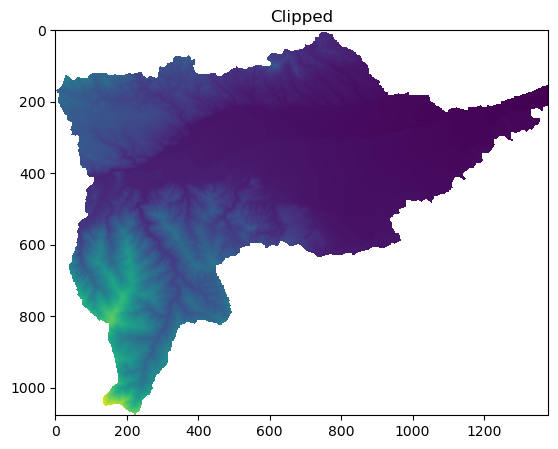

In [2]:
path_to_tif = "./tet/"

resampled_raster = '{}dem_clipped.tif'.format(path_to_tif)

dem = rio.open(resampled_raster)  # read in tif file
topo = dem.read(1).astype(float)  # assume that elevation is in the first band
topo[topo <= 0] = np.nan  # replace -9999 with nan

plt.figure(figsize=[10,5])
plt.imshow(topo)
plt.title('Clipped')
plt.show()

### Slope on edge

In [3]:
slope = topo[:, -2] - topo[:, -1]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/25)

slope = topo[:, -3] - topo[:, -1]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/50)

slope = topo[:, -3] - topo[:, -2]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/25)


0.000442119449764
0.00045720413576
0.000472288821757


## 2. Resample DEM at at lower resolution using mean and minimum criteria

Again, using `Qgis`, so run the following python script
```
python resample-dem.py
```
and now there are two DEMs

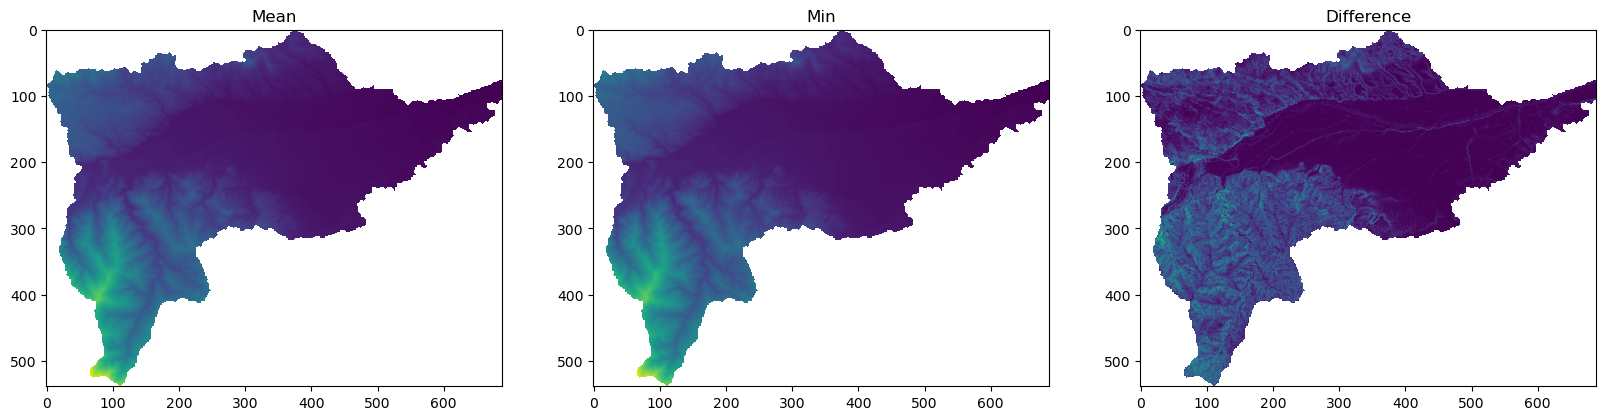

In [4]:
resampled_raster = '{}dem_50m_mean.tif'.format(path_to_tif)

dem = rio.open(resampled_raster)  # read in tif file

topo_mean = dem.read(1).astype(float)  # assume that elevation is in the first band
topo_mean[topo_mean <= 0] = np.nan  # replace -9999 with nan

resampled_raster = '{}dem_50m_min.tif'.format(path_to_tif)

dem = rio.open(resampled_raster)  # read in tif file
topo_min = dem.read(1).astype(float)  # assume that elevation is in the first band
topo_min[topo_min <= 0] = np.nan  # replace -9999 with nan

# Gqis has left a buffer around the DEM, so the left does not touch the boundary.
topo_mean = topo_mean[:,:-1]
topo_min = topo_min[:,:-1]

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(topo_mean)
plt.title('Mean')
plt.subplot(132)
plt.imshow(topo_min)
plt.title('Min')
plt.subplot(133)
plt.imshow(topo_mean-topo_min)
plt.title('Difference')
plt.show()

## 3a. Run D4 pit filling algorithm on minimum DEM

I will convert the DEM to ascii format and then run the `SinkFiller` algorithm from `LandLab` on the minimum 200 m DEM.

In [5]:
def numpy2asc(array, tiffile, ascfile):
    """
    Function to convert a geotiff (.tif) file into an ascii file (.asc)
    :param tiffile: input geotiff file name
    :param ascfile: output ascii file name (CAESAR expects .asc)
    :return: None
    """
    rio_array = rio.open(tiffile)  # read in tif file
    
    # array = np.flipud(in_array)# DEMs are upside down
    
    f = open(ascfile, 'w')
    f.write('ncols         {}\n'.format(np.shape(array)[1]))
    f.write('nrows         {}\n'.format(np.shape(array)[0]))
    f.write('xllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[0]))
    f.write('yllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[1]))
    f.write('cellsize      {}\n'.format(rio_array.transform[0]))
    f.write('NODATA_value  -9999\n')

    pix = '{0} '
    for i in range(np.shape(array)[0]):
        for j in range(np.shape(array)[1]):
            if np.isnan(array[i, j]) == True:
                f.write(pix.format(int(-9999)))  # need to replace nan with -9999
            elif array[i, j] <= 0:
                f.write(pix.format(int(-9999)))  # need to replace 0 with -9999
            else:
                f.write(pix.format(array[i, j]))
        f.write("\n")
    f.close()

In [6]:
dem_asc = '{}dem_050m_min.asc'.format(path_to_tif)
numpy2asc(topo_min, resampled_raster, dem_asc)

In [7]:
# Load in minimum DEM
(rmg, z) = read_esri_ascii(dem_asc, name='topographic__elevation')

# run the sink filling algorithm
rmg.set_watershed_boundary_condition(z)
sf = SinkFiller(rmg, routing='D4', apply_slope=False)
sf.fill_pits()

dem_filled = '{}dem_050m_min_filled.asc'.format(path_to_tif)
if os.path.isfile(dem_filled):
    os.remove(dem_filled)
write_esri_ascii(dem_filled, rmg, names='topographic__elevation')

['./tet/dem_050m_min_filled.asc']

In [8]:
def asc2numpy(ascfile):
    """
    Function to read in an ascii file (.asc) and return a Numpy array
    :param ascfile: input ascii file name
    :return ncols: number of columns
    :return nrows: number of rows
    :return geotransform: the geo-transfrom info
    :return data: a numpy array of the ascii data
    """

    try:
        gdal_data = gdal.Open(ascfile)  # use GDAL to open the ascii fle
        ncols = gdal_data.RasterXSize  # get the number of columns
        nrows = gdal_data.RasterYSize  # get the number of rows
        geotransform = gdal_data.GetGeoTransform()  # get the geo-transform info
        data_array = gdal_data.ReadAsArray().astype(float)  # convert the data into a numpy array
        data_array[data_array <= -9999] = np.nan  # replace -9999 with nan

        return ncols, nrows, geotransform, data_array

    except:
        print('cannot open {}'.format(ascfile))


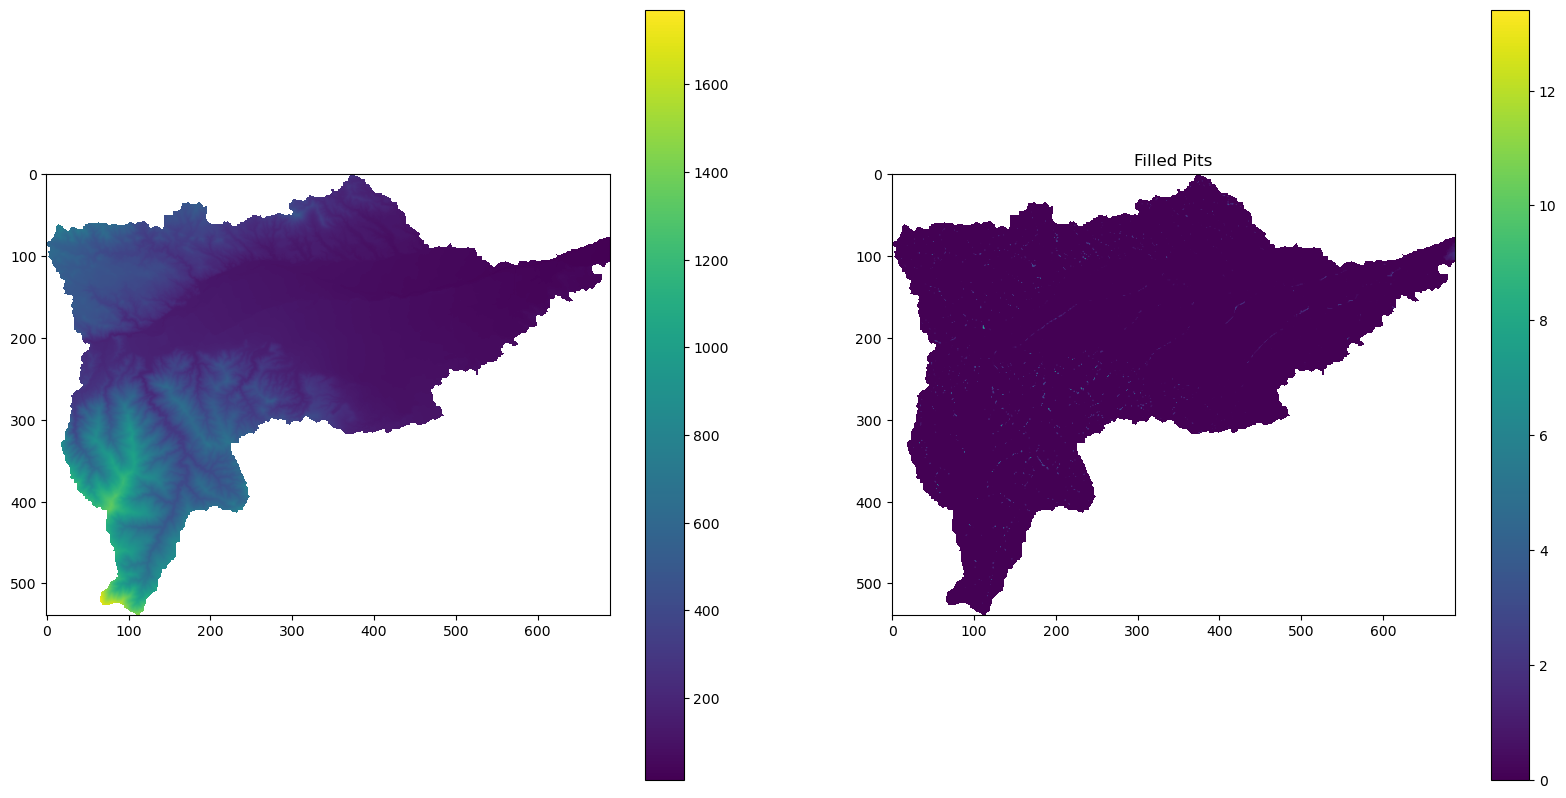

In [9]:
nx, ny, geotransform, dem_min = asc2numpy(dem_asc)
nx, ny, geotransform, dem_fill = asc2numpy(dem_filled)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(dem_fill)
plt.colorbar()
plt.subplot(122)
plt.imshow(dem_fill - dem_min)
plt.colorbar()
plt.title('Filled Pits')
plt.show()

In [10]:
ul = (geotransform[0], geotransform[3])
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])
print(ll)

(660012.5, 6156437.5)


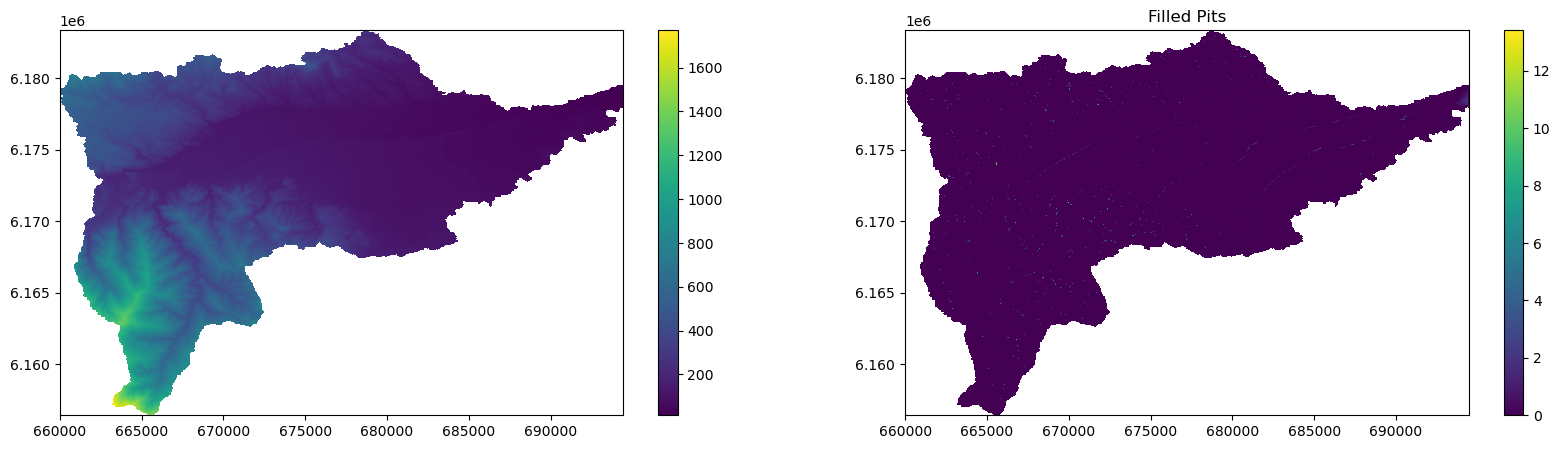

In [11]:
dx = geotransform[1]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X,Y = np.meshgrid(x,y, indexing='xy')

plt.figure(figsize=[20,5])
plt.subplot(121)
plt.pcolormesh(X, Y, dem_fill)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X, Y, dem_fill - dem_min)
plt.colorbar()
plt.title('Filled Pits')
plt.show()

## 3b. Run D4 pit filling algorithm on mean DEM

I will convert the DEM to ascii format and then run the `SinkFiller` algorithm from `LandLab` on the mean 200 m DEM.

In [12]:
dem_asc = '{}dem_050m_mean.asc'.format(path_to_tif)
numpy2asc(topo_mean, resampled_raster, dem_asc)

In [13]:
# Load in mean DEM
(rmg, z) = read_esri_ascii(dem_asc, name='topographic__elevation')

# run the sink filling algorithm
rmg.set_watershed_boundary_condition(z)
sf = SinkFiller(rmg, routing='D4', apply_slope=False)
sf.fill_pits()

dem_filled = '{}dem_050m_mean_filled.asc'.format(path_to_tif)
if os.path.isfile(dem_filled):
    os.remove(dem_filled)
write_esri_ascii(dem_filled, rmg, names='topographic__elevation')

['./tet/dem_050m_mean_filled.asc']

In [14]:
nx, ny, geotransform, dem_mean = asc2numpy(dem_asc)
nx, ny, geotransform, dem_mean_fill = asc2numpy(dem_filled)

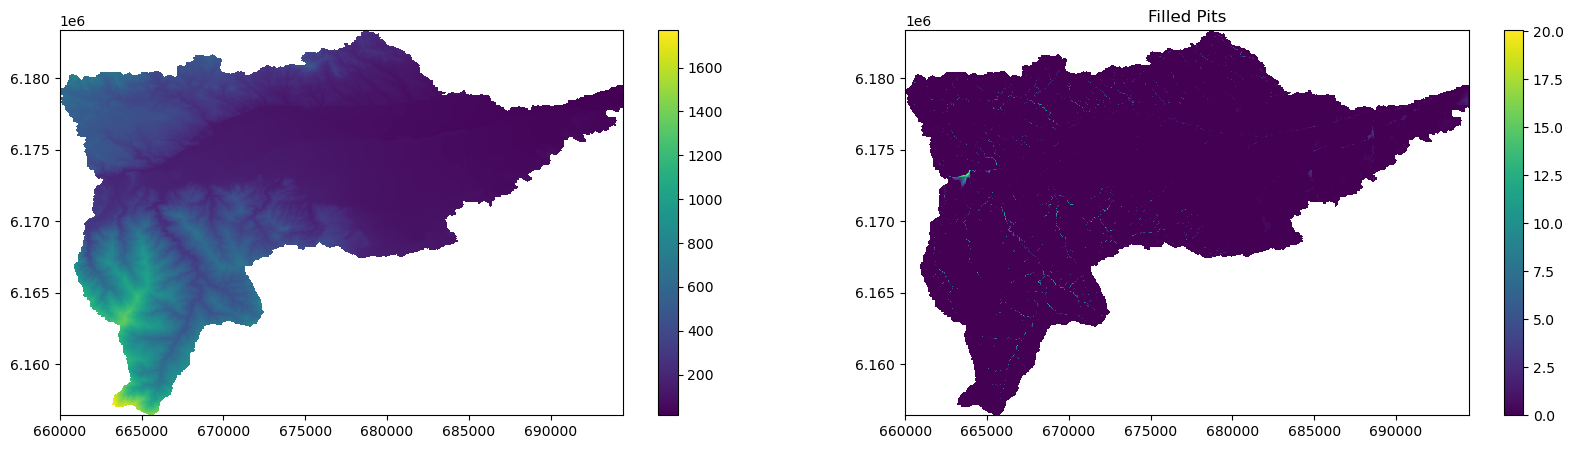

In [15]:
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])
dx = geotransform[1]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X,Y = np.meshgrid(x,y, indexing='xy')



plt.figure(figsize=[20,5])
plt.subplot(121)
plt.pcolormesh(X, Y, dem_mean_fill)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X, Y, dem_mean_fill - dem_mean)
plt.colorbar()
plt.title('Filled Pits')
plt.show()

## 4. Run CL on the pit filled minimum DEM to get flow network

This step is to allow us to sample the regions of the pit filled minimum DEM to use to replace the mean resampled DEM in the final step.
```
cp tet/dem_050m_min_filled.asc tet/hydrology-only-model/input_data/.
cd tet/hydrology-only-model
bash run_HC.sh
```


Take the final output from the hydrology only run to see where water collects within the DEM

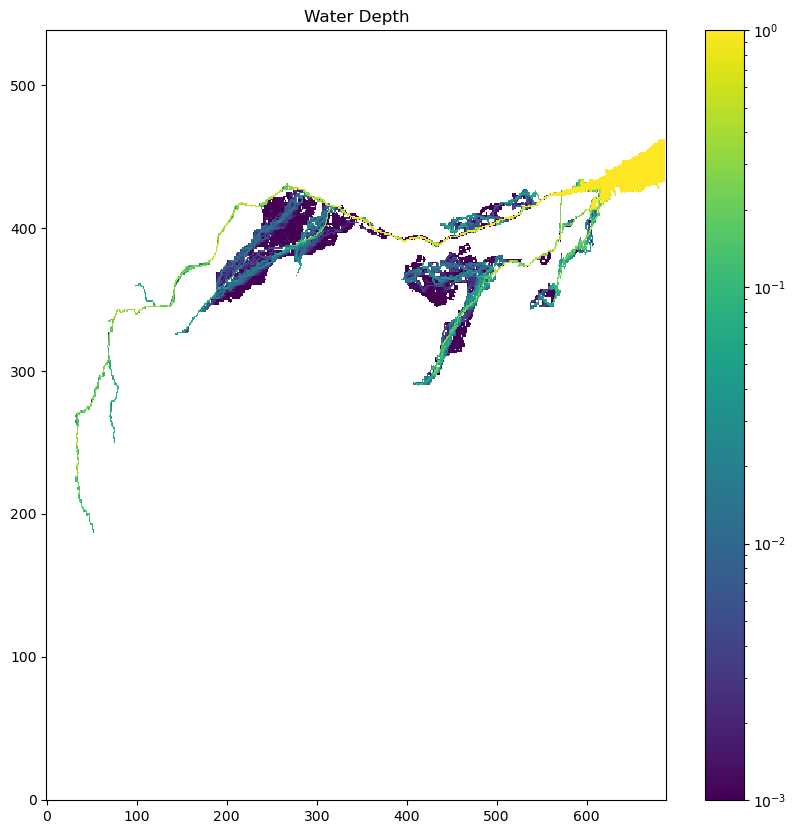

In [16]:
dem_water_file = 'tet/hydrology-only-model/results/WaterDepths216000.asc'
nx, ny, geotransform, dem_water = asc2numpy(dem_water_file)

x = np.linspace(0, nx-1, nx)
y = np.linspace(ny-1, 0, ny)
X,Y = np.meshgrid(x,y, indexing='xy')

plt.figure(figsize=[10,10])
plt.pcolormesh(X, Y, dem_water, norm=colors.LogNorm(vmin=1e-3, vmax=1e-0), shading='auto')
plt.colorbar()
plt.title('Water Depth')
plt.show()

## 5 Replace regions with water in the DEM 

We chose to replace values from the mean DEM with those from the pit filled minimum DEM when the water depth is greater than 0.05 m

In [17]:
topo_preproc = dem_mean_fill.copy()  # pit filled mean DEM
topo_preproc[dem_water > 0.05] = dem_fill[dem_water > 0.05]

In [18]:
dem_asc = '{}dem_050m_preproc.asc'.format(path_to_tif)
numpy2asc(topo_preproc, resampled_raster, dem_asc)

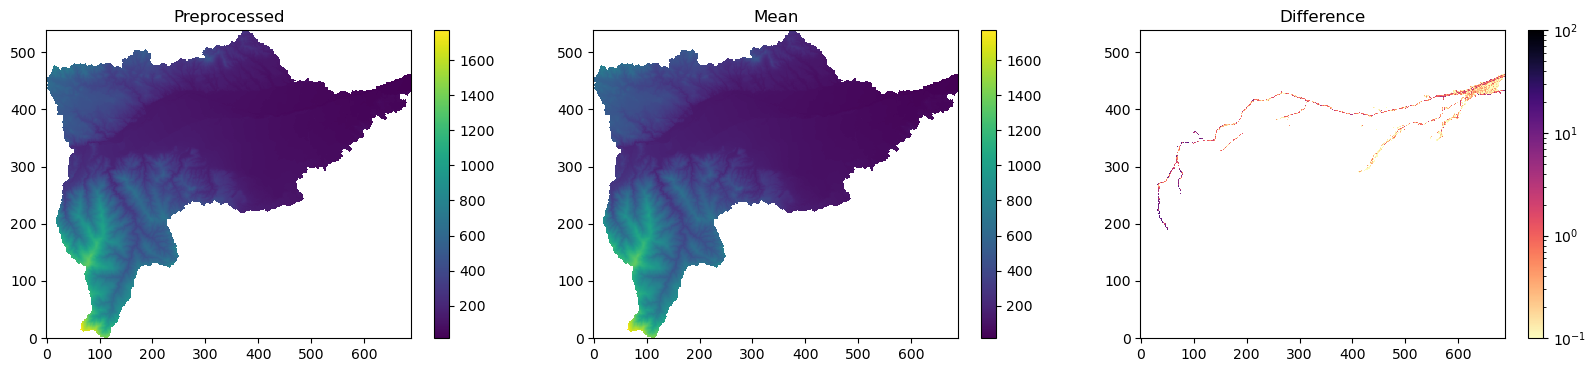

In [19]:
plt.figure(figsize=[20,4])
plt.subplot(131)
plt.pcolormesh(X, Y, topo_preproc)
plt.title('Preprocessed')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(X, Y, topo_mean)
plt.colorbar()
plt.title('Mean')
plt.subplot(133)
plt.pcolormesh(X, Y, topo_mean - topo_preproc, norm=colors.LogNorm(vmin=1e-1, vmax=1e2), cmap='magma_r', shading='auto')
plt.colorbar()
plt.title('Difference')
plt.show()

### Get esdge slope

In [32]:
slope = topo_preproc[:, -2] - topo_preproc[:, -1]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/50)
print(np.max(slope)/50)

slope = topo_preproc[:, -3] - topo_preproc[:, -1]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/100)
print(np.max(slope)/100)

slope = topo_preproc[:, -3] - topo_preproc[:, -2]
slope[np.isnan(slope)] = 0
print(np.mean(slope)/50)
print(np.max(slope)/50)

0.00102570521367
0.0708499908447
0.000822697446607
0.133725013733
0.000629708249405
0.196600036621


In [26]:
np.nanmax(topo[:, -1])

46.430000305175781